# Snowball Version 2.0 User Manual

The Snowball 2.0 is an upgrade from the previous Snowball parser integrated into ChemDataExtractor 2.0. It is a sentence-level **NLP parser** based on the modified Snowball algorithm, which is a semi-supervised machine-learning method to extract chemical relationships from text. For more detail, please refer to the papers [here](https://www.nature.com/articles/sdata2018111) and [here](https://www.nature.com/articles/s41597-022-01294-6). 

This user manual consists of a summary of the **basic concepts**, a brief description of the **major changes**, and a guide on **how to use the code**, with some **examples**. 



---


# Basic Concepts

**Entity**

An entity object is a parsed expression of a chemical string, such as a *compound*, a *specifier*, a *raw_value*, or a *raw_unit*. It contains the text and positional information of the chemical text tokens in a sentence, as well as a tag made of the name of property model and its syntactic function, such as *bandgap__specifier* or *compound__name*. 



**Element**

Elements consist of all text tokens in a sentence that are not entities. Depending on the position of entities, elements can be *prefix* (before the first entity), *middle* (between two entities), or *suffix* (after the last entity). A sentence can have only $1$ prefix and $1$ suffix, but $n-1$ middles, where $n$ is the number of entities in the sentence. The number of text tokens in prefix and suffix can be any non-negative integer, including zero. 



**Relationship**

A relationshiop is a set of related entities, such as (compound, specifier, raw_value, raw_unit). It is essentially the same as a data record in a database. 



**Phrase**

A phrase object is basically a pasrsed sentence, which is made of entities and elements. Multiple relationships can co-exist in one phrase, and they can share some of the entities. e.g. sentence *``The TiO2 sample has a band gap of 3.2 eV.``* parses as *``(prefix, compound__name, middle_1, bandgap__specifier, middle_2, raw__value, middle_3, raw__unit, suffix)``*.



**Order**

The order of a phrase is defined by the number of entities and their relative positions. Only phrases of the same order are comparable. 



**Cluster**

A cluster/sub-cluster is an ensemble of phrases of the same order. Each cluster also carries an extraction pattern. 



**Main Cluster**

A main cluster is an ensemble of several sub-clusters of the same order, but different textual similarity. 



**Extraction Pattern**

An extraction pattern is a combination of the most frequent elements of all phrases in a sub-cluster, with entities as place holders. An extraction pattern is almost equivalent to a phrase, but also represents the characteristics of a cluster. 



**Confidence**

A confidence is a value between 0% and 100%, which indicates the correctness of an object, which can be a relationship, a phrase, or an extraction pattern. 



---




# Major Changes & New Methods

**1. Support for nested property models**

The Snowball model supports nested property models. For best performance and stability, only use 2-level nested property models. When using higher level nested models, avoid setting the requirement of nested models to False. 



**2. Separated training and clustering processes**

The clustering process is now manually executed after training rather than during training, and the process is fully reversible, meaning a Snowball model can be clutsered and unclustered, and the user can change the hyper-parameters without re-training a Snowball model. 



**3. Support for generic model training**

The Snowball model is no longer property-specific: other Snowball models trained on different property models can be imported to a new Snowball model to shorten the training period, or avoid training completely. This feature is also compatible with nested property models. 



**4. Added entity-based training**

The training process automatically switches to entity-based training rather than relationship-based training when too many candidate relationships are detected in a sentence, so that the user can manually construct the correct relationships using candidate entities, instead of going through hundreds of candidate relationships. The threshold number is also adjustable. 



**5. More clustering methods**

The clustering process now features 5 methods: *max*, *min*, *first*, *all*, and *best*. *all* is the original method where all matching clusters are updated with new phrases; *first* means only the first matching cluster is updated; and *best* means the cluster with highest similarity score is updated. *max* and *min* are new similarity-triangle-based methods that maximize or minimize the number of clusters to optimize for performance or efficiency.



**6. Removed the hyper-parameter learning rate**

The hyper-parameter learning rate is deprecated, so now the effective learning rate is always 1. Revised confidence calculations were implemented so that this can be done without the drawbacks of fluctuating confidence scores, which is usualy caused by not setting learning rate to 0 during data extraction. 



**7. New data extraction process**

* A second similarity threshold, $\tau_{sim\_l}$, is introduced to describe the match between two phrases: good, ok, or bad. Using $\tau_{sim\_l}$ is equivalent to lowering $\tau_{sim}$ in Snowball 1.0 during data extraction to increase recall. By definition, $\tau_{sim\_l} \leq \tau_{sim\_h}$. 
* The minimum confidence threshold, $\tau_c$, is no longer a post-processing filter. Instead, it controls the generation of new clusters during data extraction. An unseen phrae with confidence score higher than $\tau_c$ can be assigned to its own cluster. 
* Now there are two equations to calculate the confidence score of the relations $r_c$ of a new phrase $p_c$:

  $C\left(r_c\right)= 1 - \sqrt[n]{\prod_{i=1}^{n} \left[ 1- C\left(P_i\right) \cdot sim\left( p_c,P_i \right) \right]}$, when the highest similarity score $< \tau_{sim\_h}$; the product multiplies over all matching clusters, including the newly generated ones during data extraction. 

  $C\left(r_c\right)= 1 - \sqrt[n]{ \prod_{i=1}^{n} \left[ 1- C\left(p_i\right) \cdot sim\left( p_c,p_i \right) \right]}$, when 
the highest similarity score $\geq \tau_{sim\_h}$; $n$ multiplies over all phrases within this cluster. 

* $\tau_{sim\_h}$, $\tau_{sim\_l}$, and $\tau_c$ together determine what happens to a new data record, according to the figure below. 




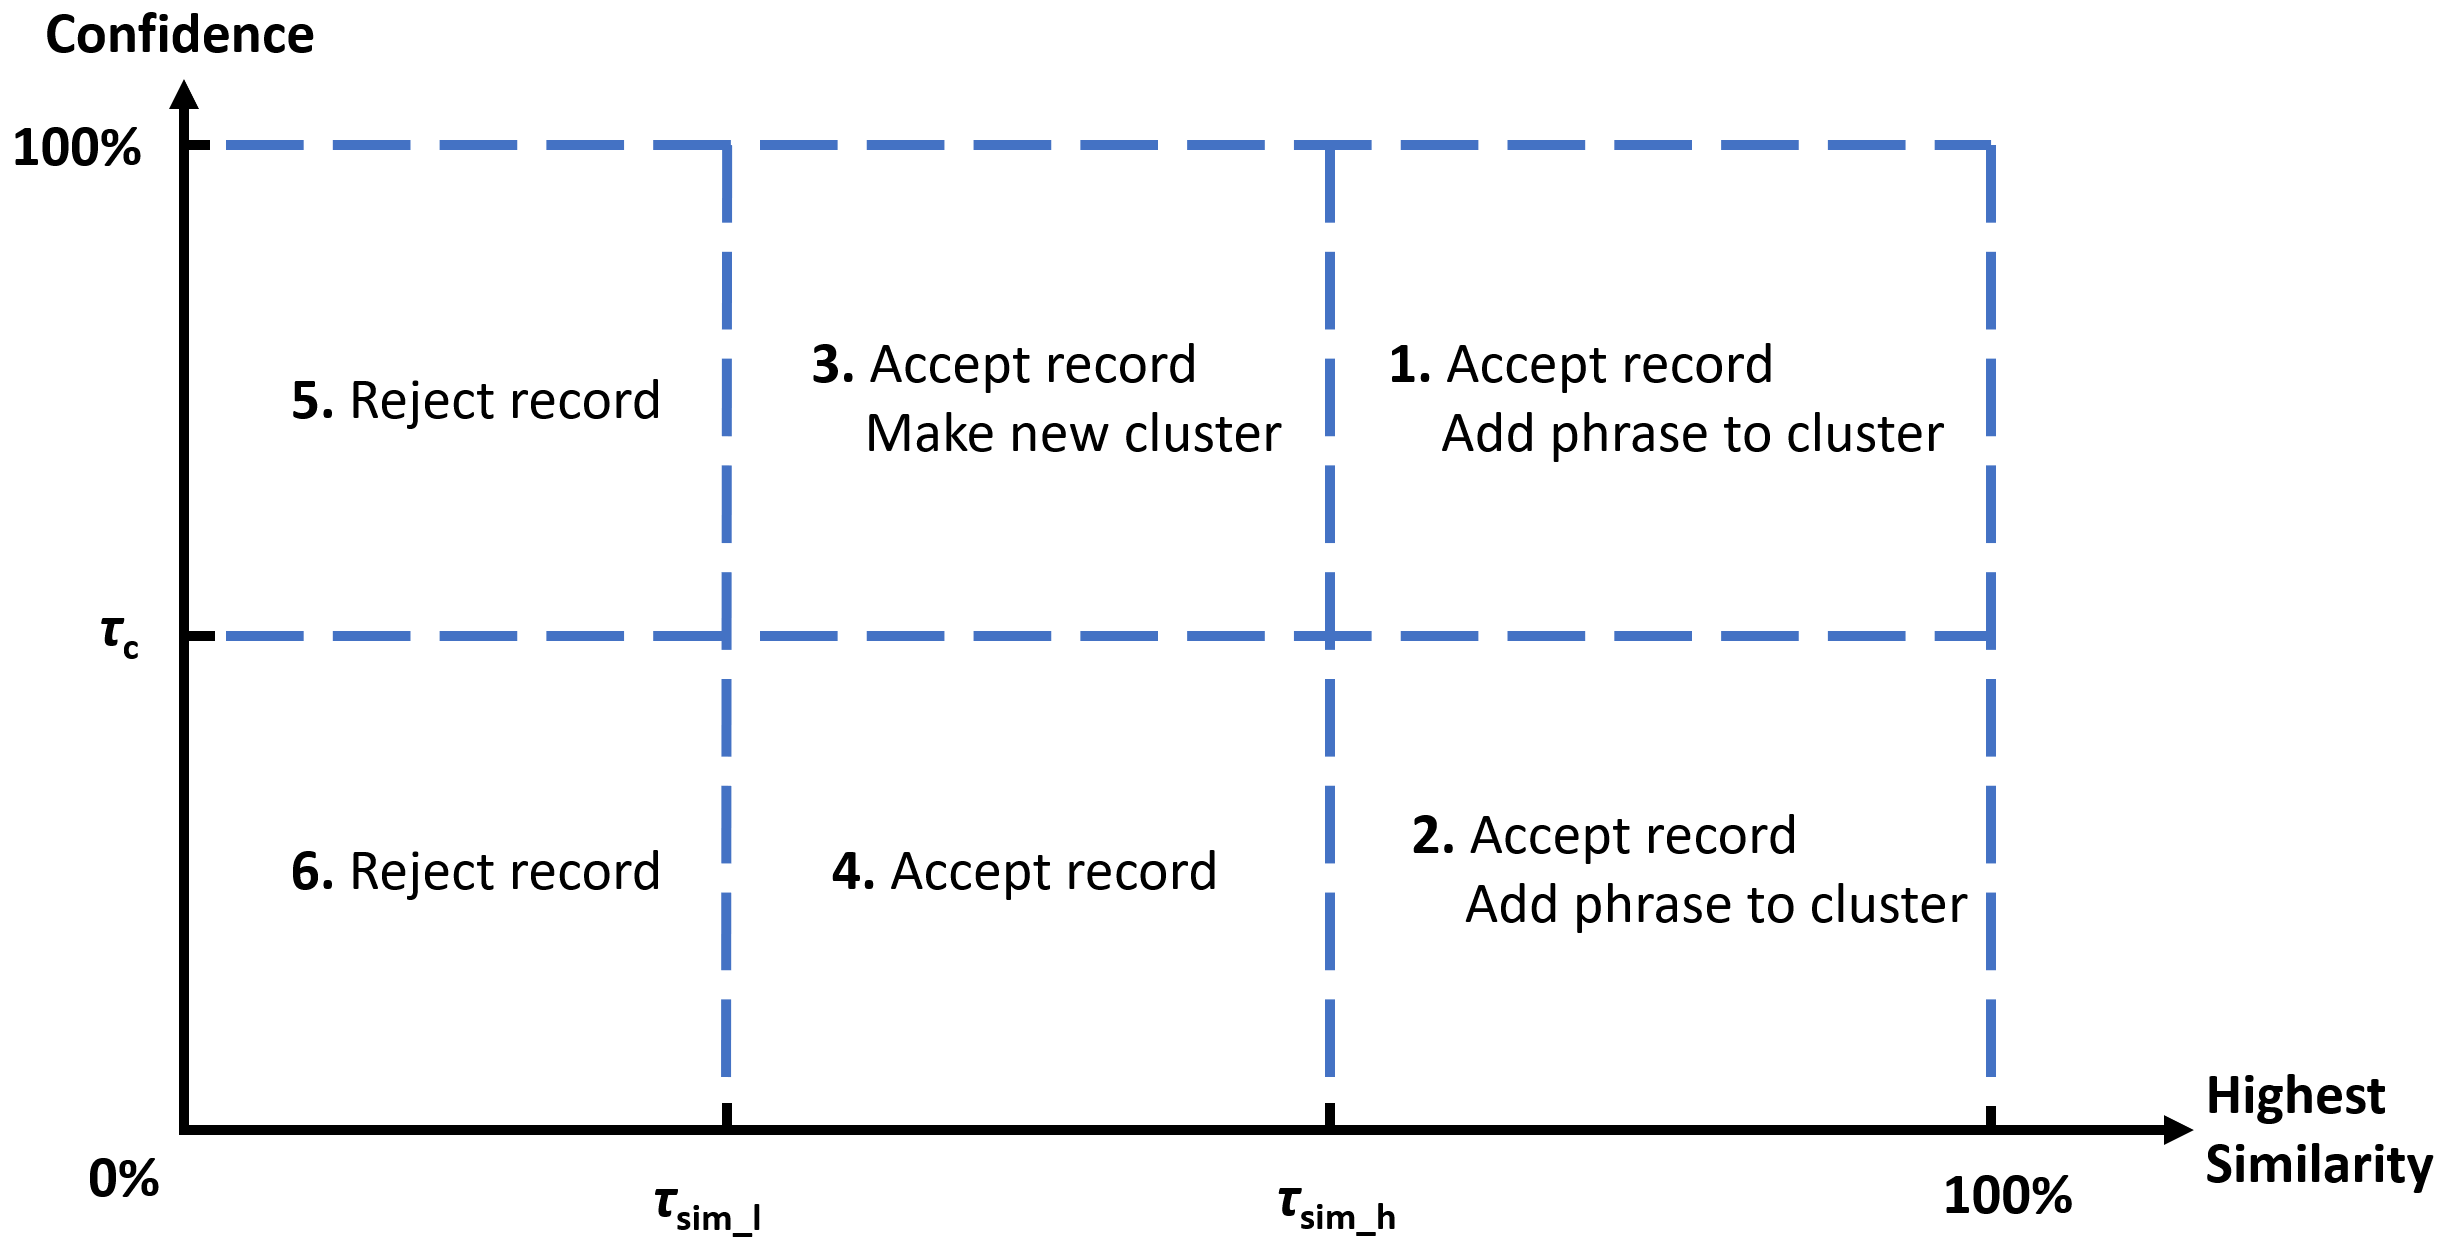


---


# Initializing Snowball

First, import the Snowball module. 

In [8]:
from chemdataextractor.relex.snowball import Snowball

We also need a property model. Let's try a nested model here. Note: do not use underscore “_” when naming property models! Also, it is strongly recommended to set `compound.model_class.fields['names'].required = True` for the parent property. 

More examples of property models can be found [here](https://pubs.acs.org/doi/10.1021/acs.jcim.1c00446?goto=supporting-info).

In [9]:
from chemdataextractor.model import StringType, ListType, ModelType, Compound
from chemdataextractor.parse import R, I, W, Optional, merge, join, AutoSentenceParser
from chemdataextractor.model.units.energy import EnergyModel
from chemdataextractor.model.units.temperature import TemperatureModel
from chemdataextractor.doc import Sentence

class Temperature(TemperatureModel):
    specifier_expression =(I('at') | W('T')).add_action(join)
    specifier = StringType(parse_expression=specifier_expression, required=False, updatable=False)
    compound = ModelType(Compound, required=True, updatable=False, binding=True)
    parsers = [AutoSentenceParser()]

class BandgapTemp(EnergyModel):
    specifier_expression =((I('band') + R('gaps?')) | I('bandgap') | I('band-gap') | I('Eg')).add_action(join)
    specifier = StringType(parse_expression=specifier_expression, required=True, updatable=True)
    compound = ModelType(Compound, required=True, contextual=True, binding=True, updatable=False)
    compound.model_class.fields['names'].required = True
    parsers = [AutoSentenceParser()]
    temperature = ModelType(Temperature, required=False)

We can now initialize a Snowball instance.

In [10]:
sb1 = Snowball(model=BandgapTemp)

There should be 3 files created inside the folder *Snowball_model*: a *modelName.pkl* file for the main Snowball model, a *modelName_clusters.txt* file for all the clusters, and a *modelName_phrases.txt* file for all unclustered phrases. The two txt files are not required for the parser to run. 

The argument `model` is the only required field. We can also specify other useful parameters. All these parameter are attributes of the Snowball instance that can be changed on the fly during training, so we can leave the hyper-parameters as default for now and optimize them later. 
* `tc`: float, the minimum confidence threshold for cluster generation, default is $80\%$. 
* `tsim_h`: float, the higher similarity threshold, default is $80\%$.
* `tsim_l`: float, the lower similarity threshold, default is `tsim_h`$/2$.
* `prefix_weight`, `middle_weight`, and `suffix_weight`: float, the weight vector of phrases, default is $10\%$, $80\%$, and $10\%$. They sould add up to $100\%$. 
* `prefix_length` and `suffix_length`: integer, the maximum number of text tokens in prefix and suffix, default is $1$ and $1$. 
* `max_candidate_combinations`: integer, the maximum number of candidate relationships found in a candidate phrase before the phrase is ignored (the parameter and this value are NOT equal, they only scale with each other), default is $5000$. Reduce this value if code runs too slow. 
* `value_before_unit`: boolean, if a unit is allowed without a value in front of it, default is `True`. 
* `entity_training_threshold`: integer, the maximum number of candidate relationships allowed in a sentence before switching to entity-based training, default is $20$. Increase this value if you have sharp eyes. 
* `save_dir`: string, the folder name to save the Snowball model (which is also a folder), default is `Snowball_model`. 
* `file_name`: string, the name of the Snowball files, default is the property model name. 
* `clustering_method`: string, allowed values are `max`, `min`, `first`, `all`, and `best`, default is `max`. 
* `second_round`: boolean, whether or not the second confidence equation is executed, default is `True`. This is for debugging purposes only, do NOT turn it off. 
* `compound_filter`: name of a custom function that takes a compound name as string and returns a boolean of whether the compound is good or not. This improves parser performance by ruling out bad candidate phrases before calculating their confidence scores. Default is `None`, as in the filter accepts all compounds. 
* `phrase_filter`: name of a custom function that takes a phrase object and returns a boolean of whether the phrase is good or not. This takes data cleaning before data extraction, which improves parser performance. Default is `None`. 
* `normalization`: boolean, whether or not the root n in the confidence equation is calculated, default is `True`. Turning this off would emulate Snowball 1.0 behavior, which gives slightly higher precision but much lower recall. 



---



# Training

**Different types of training data**

We can now proceed to training. Suppose we have a file named `resource.txt` which contains one sentence `TiO2 has a large band gap of 3.2 eV at 300 K. `, then to train the Snowball model, simply run

In [12]:
sb1.train_from_file(filename='resource.txt')

Initialising AllenNLP model ✔[K25h


TiO2 has a large band gap of 3.2 eV at 300 K.

Candidate 0: <(TiO2,compound__names,0,1), (band gap,bandgaptemp__specifier,4,6), (3.2,bandgaptemp__raw_value,7,8), (eV,bandgaptemp__raw_units,8,9), (at,temperature__specifier,9,10), (300,temperature__raw_value,10,11), (K,temperature__raw_units,11,12)>

Candidate 1: <(TiO2,compound__names,0,1), (band gap,bandgaptemp__specifier,4,6), (3.2,bandgaptemp__raw_value,7,8), (eV,bandgaptemp__raw_units,8,9)>

relationships: 0
 


Alternatively, we can train from a folder/corpus:

In [13]:
sb1.train_from_corpus(corpus='folderName')

Training 1/1: resource.txt
Already trained: resource.txt



Or we can train directly from sentences (or documents), mostly for testing purposes: 

In [14]:
s1 = Sentence('TiO2 has a large band gap of 3.2 eV at 300 K. ')
sb1.train_from_sentence(s1)



TiO2 has a large band gap of 3.2 eV at 300 K. 

Candidate 0: <(TiO2,compound__names,0,1), (band gap,bandgaptemp__specifier,4,6), (3.2,bandgaptemp__raw_value,7,8), (eV,bandgaptemp__raw_units,8,9), (at,temperature__specifier,9,10), (300,temperature__raw_value,10,11), (K,temperature__raw_units,11,12)>

Candidate 1: <(TiO2,compound__names,0,1), (band gap,bandgaptemp__specifier,4,6), (3.2,bandgaptemp__raw_value,7,8), (eV,bandgaptemp__raw_units,8,9)>

relationships: 0
 


True

**Relationship-based training**

When a sentence is simple enough, e.g. the number of candidate relationships is less than `entity_training_threshold`, we choose the correct relationships out of all candidate relationships. Separate the indices with comma, then hit enter. If there are no correct relationships, then press enter directly. 

*the last two values in an entity are the starting and ending positions of this entity in the sentence, which can be useful when the token appears multiple times in the sentence. 

*if a relationship has multiple specifiers, treat them as separate relationships. (But for the sake of recall, try to only select the most relevant one, since more specifiers indicate higher order, which are less common)

*no brackets are allowed in the units, even if POS tagging says so. This simplifies training by quite a bit, but records from a different parser will have different raw_units. 

*if needed, press ctrl+C to abort training, or if there is a typo+Enter situation, simply delete the latest phrase with `del sb1.phrases[-1]`.

*if a sentence requires modifications for training, press n + Enter to mark the sentence in modelName\_notes.txt file, so that it can be dealt with later. 

In [18]:
s2 = Sentence('Si and Cu2O have band gaps of 1.1 and 3.3 eV at 300 K. ')
sb1.train_from_sentence(s2)



Si and Cu2O have band gaps of 1.1 and 3.3 eV at 300 K. 

Candidate 0: <(Si,compound__names,0,1), (band gaps,bandgaptemp__specifier,4,6), (1.1,bandgaptemp__raw_value,7,8), (3.3,temperature__raw_value,9,10), (eV,bandgaptemp__raw_units,10,11), (at,temperature__specifier,11,12), (K,temperature__raw_units,13,14)>

Candidate 1: <(Si,compound__names,0,1), (band gaps,bandgaptemp__specifier,4,6), (1.1,bandgaptemp__raw_value,7,8), (eV,bandgaptemp__raw_units,10,11), (at,temperature__specifier,11,12), (300,temperature__raw_value,12,13), (K,temperature__raw_units,13,14)>

Candidate 2: <(Si,compound__names,0,1), (band gaps,bandgaptemp__specifier,4,6), (1.1,temperature__raw_value,7,8), (3.3,bandgaptemp__raw_value,9,10), (eV,bandgaptemp__raw_units,10,11), (at,temperature__specifier,11,12), (K,temperature__raw_units,13,14)>

Candidate 3: <(Si,compound__names,0,1), (band gaps,bandgaptemp__specifier,4,6), (3.3,bandgaptemp__raw_value,9,10), (eV,bandgaptemp__raw_units,10,11), (at,temperature__specifier,1

True

**Entity-based training**

When a sentence is complicated enough, e.g. having candidate relationships more than `entity_training_threshold`, the programme switches to entity-based training, and we choose the correct entities to construct individual relationships, one at a time. We first need to type in the number of relationships, then followed by several single-answer choices. This should make the training process of complex sentences much easier. A relationship is printed once it is completed, so do double check if everything is correct. 

*again, press ctrl + C to abort if there is a typo. 


In [19]:
s2 = Sentence('Si and Cu2O have band gaps of 1.1 and 3.3 eV at 300 K. ')
sb1.entity_training_threshold = 10
sb1.train_from_sentence(s2)



Si and Cu2O have band gaps of 1.1 and 3.3 eV at 300 K. 

[(Si,compound__names,0,1),
 (Cu2O,compound__names,2,3),
 (band gaps,bandgaptemp__specifier,4,6),
 (1.1,bandgaptemp__raw_value,7,8),
 (1.1,temperature__raw_value,7,8),
 (3.3,bandgaptemp__raw_value,9,10),
 (3.3,temperature__raw_value,9,10),
 (eV,bandgaptemp__raw_units,10,11),
 (at,temperature__specifier,11,12),
 (300,bandgaptemp__raw_value,12,13),
 (300,temperature__raw_value,12,13),
 (K,temperature__raw_units,13,14)]
 
How many relations: 2
 


Si and Cu2O have band gaps of 1.1 and 3.3 eV at 300 K. 

Constructing relationship 1/2: 


compound__names 0: (Si,compound__names,0,1)

compound__names 1: (Cu2O,compound__names,2,3)

compound__names: 0
 


bandgaptemp__specifier 0: (band gaps,bandgaptemp__specifier,4,6)

bandgaptemp__specifier: 0
 


bandgaptemp__raw_value 0: (1.1,bandgaptemp__raw_value,7,8)

bandgaptemp__raw_value 1: (3.3,bandgaptemp__raw_value,9,10)

bandgaptemp__raw_value 2: (300,bandgaptemp__raw_value,12,13)

bandgapt

True

**Pausing and resuming**

Snowball remembers the file names during training, and automatically skips the files that are already used, as long as we only use `train_from_corpus` and `train_from_file`, not `train_from_sentence`. So we do not need to change the training folder if more files arrive. 

we can pause the training process any time, whether because of a BSoD(blue screen of death) or other reasons. Snowball also automatically saves itself as a pkl file whenever something is added, so there is no need to worry about losing data. To resume training, we can initialize a new model by loading the already trained model from file:

In [ ]:
sb1 = Snowball.load(path='BandgapTemp.pkl')

Again, no need to manually skip through the files trained previously. 



**Importing data**

In version 2.0, the Snowball model is generic, that it is independent of the property model. We can import labeled sentences from other Snowball models, even if they are trained from different properties. For example, say we have previously trained a Snowball model based on the Curie temperature of ferromagnetic materials, we can import the labeled sentences in this model using

In [ ]:
sb1.import_data(path='Curie.pkl', confidence_limit=1.0)

Simply replace the `path` with the correct pkl file name. All hyper-parameters are automatically adjusted to the current definition, so no need to worry about different prefix lengths, etc. We can also import only the correct phrases, those with confidence scores higher than the `confidence_limit` (optional argument). By default this value is 100%, meaning that we only accept phrases curated during training, which are guaranteed to be correct. 

Note that for better compatibility across different versions of ChemDataExtractor, or different Python environments, or different devices, it is recommended to save the labelled phrases to a separate file by running `sb1.export_to_list(path='BandgapTemp_list.pkl')` (the path argument is optional). This will create a new file which is a list of phrases rather than a Snowball instance. This file can also be imported with the same `sb1.import_data(path)` method. 



---



# Extracting Data

**Clustering**

Up until now, all labeled sentences are stored as independent phrases. Once we assign them into clusters, the simiarity threshold `tsim_h` can no longer be changed, so it is best to specify its value now. 

In [20]:
sb1.tsim_h = 0.95 

To cluster the phrases, simply run

In [21]:
sb1.cluster_all(method='max')

Clustering BandgapTemp.

Clustered 5 sentences; now have 2 clusters.



For best performance, the recommended clustering method is `max`, which can be specified using the argument `method`. For reference, Snowball Version 1.9 is equivalent to `method=best`, and Version 1.0 is equivalent to `method=all`. 

The Snowball parser will not work if it is not clustered. To examine if the clustering process has been done, we can check that `sb1.clustered == True`, and `len(sb1.phrases) == 0`, and `len(sb1.clusters) != 0`.


Similarly, an already clustered Snowball model can be unclustered:

In [ ]:
sb1.uncluster(training_only=False)

We can also set the argument `training_only=True` to remove all phrases not generated from training, so that we can experiment with different similarity thresholds. 



**Finding new relationships**

Now we can use the Snowball model as a parser. First, finalize the rest of the hyper-parameters at this stage; then, add the Snowball parser to the property model's parser list. In this example, we will use the Snowball parser exclusively. 

In [22]:
sb1.tsim_l = 0.5
sb1.tc = 0.9
BandgapTemp.parsers = [sb1]

Next, we can parse an unseen sentence and find the associated records. 

In [23]:
from pprint import pprint
s3 = Sentence('ZnO features an Eg of 3.3 eV at 320 K. ')
s3.add_models([BandgapTemp])
results = s3.records.serialize()
pprint(results)

[{'BandgapTemp': {'compound': {'Compound': {'names': ['ZnO']}},
                  'confidence': 0.8666666666666665,
                  'raw_units': 'eV',
                  'raw_value': '3.3',
                  'sentence': 'ZnO features an Eg of 3.3 eV at 320 K .',
                  'specifier': 'Eg',
                  'temperature': {'Temperature': {'compound': {'Compound': {'names': ['ZnO']}},
                                                  'raw_units': 'K',
                                                  'raw_value': '320',
                                                  'specifier': 'at',
                                                  'units': 'Kelvin^(1.0)',
                                                  'value': [320.0]}},
                  'units': 'ElectronVolt^(1.0)',
                  'value': [3.3]}},
 {'Compound': {'names': ['ZnO']}},
 {'Temperature': {'compound': {'Compound': {'names': ['ZnO']}},
                  'raw_units': 'K',
                  'raw_value': 

As shown, the dictionary 'BandgapTemp' has a 'confidence' key, and this is the output from Snowball parser. 

*if there are no outputs from Snowball parser, try reducing `tsim_l`, and double check if the model is clustered, e.g. `sb1.clustered == True`. If that doesn't work, try printing `sb1.find_entity(s.tagged_tokens)` to check if all entities can be found. 

*it is not recommended to use multiple parsers simultaneously, e.g. AutoSentenceParser and Snowball parser; always run them separately. 


**Crossing different property models**

If needed, a Snowball parser can import phrases from other Snowball models without spending any time on training, although the performance may not be as good as it could be. For example, we can deploy the previously trained Bandgap & Temperature parser on a Diameter & Temperature model without additional training. 

*as long as a candidate relationship has the same order as a phrase in the imported file, they are comparable and the code will work; this will cause problems if dimensionless property models are involved. 

*it is recommended to reduce `tsim_l` when crossing property models, as sentences are expected to be more different. 

In [25]:
from chemdataextractor.model.units.length import LengthModel

class Temperature(TemperatureModel):
    specifier_expression =(I('at') | W('T')).add_action(join)
    specifier = StringType(parse_expression=specifier_expression, required=False, updatable=False)
    compound = ModelType(Compound, required=True, updatable=False, binding=True)
    parsers = [AutoSentenceParser()]

class DiameterTemp(LengthModel):
    specifier_expression =(I('diameter') + R('of')).add_action(join)
    specifier = StringType(parse_expression=specifier_expression, required=False, updatable=False)
    compound = ModelType(Compound, required=True, updatable=False)
    compound.model_class.fields['names'].required = True
    parsers = [AutoSentenceParser()]
    temperature = ModelType(Temperature, required=False)

sb2 = Snowball(model=DiameterTemp, tsim_l=0.5)
sb2.import_data('Snowball_model/BandgapTemp.pkl')

sb2.cluster_all()
DiameterTemp.parsers = [sb2]

s4 = Sentence('The TiO2 QD has a diameter of 10 nm measured at 150 K. ')
s4.add_models([DiameterTemp])
results = s4.records.serialize()
pprint(results)

Loading from a different property: BandgapTemp.
Loaded 5 phrases from: BandgapTemp.

Clustering DiameterTemp.

Clustered 5 sentences; now have 2 clusters.

[{'Compound': {'names': ['TiO2']}},
 {'DiameterTemp': {'compound': {'Compound': {'names': ['TiO2']}},
                   'confidence': 0.5888888888888888,
                   'raw_units': 'nm',
                   'raw_value': '10',
                   'sentence': 'The TiO2 QD has a diameter of 10 nm measured '
                               'at 150 K .',
                   'specifier': 'diameter of',
                   'temperature': {'Temperature': {'compound': {'Compound': {'names': ['TiO2']}},
                                                   'raw_units': 'K',
                                                   'raw_value': '150',
                                                   'specifier': 'at',
                                                   'units': 'Kelvin^(1.0)',
                                                   'value'

# Supplementary materials

Example phrase filter:

In [ ]:
import re

def phrase_filter(phrase):

    '''
    Data cleaning on phrase level, return a boolean of whether the phrase is valid.
    <specifier> may contain greek letters.
    text.replace('−', '-').replace('–', '-').replace('∼', '~').replace(' ', '').replace(' ', '').replace(' ', '').
    '''

    for i, entity in enumerate(phrase.entities):
        if entity.tag == 'bandgaptemp__raw_value':
            # <raw_value> contains '<' or '>', or is less than 0
            if re.search(r'[<>\-−–]', entity.text):
                return False
            # by (about/around/~/any token) + <raw_value>
            if entity.start >= 2:
                if 'by' in phrase.sentence_tokens[entity.start-2 : entity.start]:
                    return False
            else:
                if 'by' in phrase.sentence_tokens[0 : entity.start]:
                    return False
            # <raw_value> + <raw_units>
            if phrase.entities[i+1].tag == 'bandgaptemp__raw_units':
                if entity.start >= 2:
                    # shift/difference/raise/increase/decrease of + <raw_value> + <raw_units>
                    if re.search(r'(shift|difference|raise|increase|decrease)\sof', ' '.join(phrase.sentence_tokens[entity.start-2 : entity.start])):
                        return False
                    # less than/below + <raw_value> + <raw_units>
                    elif re.search(r'(less\sthan|below)', ' '.join(phrase.sentence_tokens[entity.start-2 : entity.start])):
                        return False
                if phrase.entities[i+1].end < len(phrase.sentence_tokens):
                    # <raw_value> <raw_units> + less/more/higher/wider/narrower/larger/smaller/lower/increase/decrease
                    if phrase.sentence_tokens[phrase.entities[i+1].end] in ['less', 'more', 'higher', 'wider', 'narrower', 'larger', 'smaller', 'lower', 'increase', 'decrease']:
                        return False

        elif entity.tag == 'compound__names':
            # higher/wider/narrower/larger/smaller/lower/less/more than that of <compound_names>
            if entity.start >= 4:
                if re.search(r'(higher|wider|narrower|larger|smaller|lower|less|more)\sthan\sthat\sof', ' '.join(phrase.sentence_tokens[entity.start-4 : entity.start])):
                    return False
            if entity.end < len(phrase.sentence_tokens):
                # <compound_name> + phase
                if phrase.sentence_tokens[entity.end] == 'phase':
                    return False

    return True

Example semiconductor filter:

In [ ]:
import MaterialParser

def parse_compound(material_string):

    mp = MaterialParser(verbose=False, pubchem_lookup=False, fails_log=False)
    # print(f'material_string = {material_string}')
    parts = [p for p in re.split(r'\s?/\s?|\s\(\s|\s\)|\s@\s', material_string) if p != '' and p is not None]
    # print(f'parts = {parts}')

    composition_list = {}
    for part in parts:
        material = mp.reconstruct_list_of_materials(part)
        material = material if material != [] else [(part, '')]
        # pprint(material)
        
        for m, val in material:
            try:
                result = mp.parse_material(m)
            except KeyError:
                print("KeyError: ", m)
                result = dict(material_string=m,
                    composition=[dict(formula=m, amount='1.0', elements={})])

        for i in result['composition']:
            for j in i['elements'].items():
                if j[0] not in composition_list.keys():
                    try:
                        composition_list[j[0]] = float(j[1])
                    except ValueError:
                        composition_list[j[0]] = 1
                else:
                    try:
                        composition_list[j[0]] += float(j[1])
                    except ValueError:
                        composition_list[j[0]] += 1

    # pprint(composition_list) # could be empty
    # print("\n\n\n")

    return composition_list


def semiconductor_filter(compound_name):

    '''return boolean: whether the compound is a valid semiconductor'''

    elementals = ['Ge',' Sn', 'Si', 'Se', 'Te', 'S', 'C']

    if compound_name in ['VB', 'VBM', 'CB', 'CBM', 'VOC', 'PEC']:
        return False
    elif len(compound_name) <= 4 and compound_name[-1] in ['+', '-']:
        return False
    elif (not re.search(r'[\.\-−–/:@]', compound_name)) and (not re.search(r'[A-Z]{3,}', compound_name)) and (not re.fullmatch(r'[A-Z]{2,}', compound_name)) and (not re.fullmatch(r'[A-Z]\d{2,}', compound_name)):
        compound_name = re.sub(r'\(\s?I{0,3}\s?\)', '', compound_name)
        compound_dict = parse_compound(compound_name)
        # pprint(compound_dict)
        keys = list(compound_dict.keys())
        if len(keys) == 1 and keys[0] not in elementals:
            # print(parse_compound(compound_name))
            return False

    return True